# **My name is Yahia Mohamed Nabil,**
***This notebook is for slash's AI internship***
I used a public dataset similar to what the problem you've gave to me which is fashion product images classification, There's many approaches I can solve this problem with but I decided to go with (**CNN**) as they can learn and extract features from raw pixel data without any preprocessing or feature engineering.

# **First we setup our system and import all the important libraries**

In [1]:
# essential libraries
import numpy as np
import pandas as pd

#visualization libraries
import seaborn as sns
from matplotlib import pyplot as plt

# ML/DL libraries
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import math
import os
from joblib import Parallel, delayed
from PIL import Image

2024-03-13 15:03:37.181435: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-13 15:03:37.181620: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-13 15:03:37.350678: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# **Reading the data from the csv file**

In [2]:
import csv

styles_path = "/kaggle/input/fashion-product-images-dataset/fashion-dataset/styles.csv"

with open(styles_path, 'r') as f:
    reader = csv.reader(f)
    columns = next(reader)
    rows = [row for row in reader if len(row) == len(columns)]

stylesData = pd.DataFrame(rows, columns=columns)
stylesData.head()
#where id is the image name

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012,Casual,Puma Men Grey T-shirt


# **Droping features that are not important to our classification problem**

In [3]:
stylesData.drop(
    ['gender', 'articleType', 'baseColour', 'season', 'year', 'usage', 'productDisplayName','subCategory'],
    axis = 1,
    inplace = True
)
stylesData.head()

,id,masterCategory
0,15970,Apparel
1,39386,Apparel
2,59263,Accessories
3,21379,Apparel
4,53759,Apparel


In [4]:
NUM_CORES = os.cpu_count()
NUMBER_UNIQUE_CATEGORY = stylesData['masterCategory'].nunique()
BATCH_SIZE = 32
SCALING_SIZE = (64, 64)
SEED_VALUE = 42

# **gain some important measures from the data**

In [5]:
# Get unique classes
unique_classes = stylesData['masterCategory'].unique()
print("Unique classes:", unique_classes)

# Get count of items under each class
class_counts = stylesData['masterCategory'].value_counts()
print("Count of items under each class:\n", class_counts)

Unique classes: ['Apparel' 'Accessories' 'Footwear' 'Personal Care' 'Free Items'
 'Sporting Goods' 'Home']
Count of items under each class:
 masterCategory
Apparel           21397
Accessories       11274
Footwear           9219
Personal Care      2403
Free Items          105
Sporting Goods       25
Home                  1
Name: count, dtype: int64


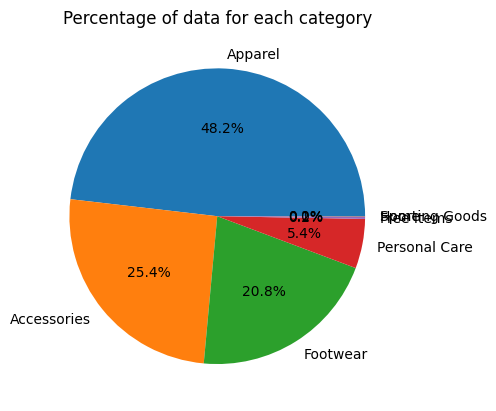

this are the percentages for being clear
masterCategory
Apparel           48.165406
Accessories       25.378174
Footwear          20.752296
Personal Care      5.409238
Free Items         0.236359
Sporting Goods     0.056276
Home               0.002251
Name: proportion, dtype: float64


In [6]:
# Calculate the percentage of each category
category_percentage = stylesData['masterCategory'].value_counts(normalize=True) * 100

# Create a pie chart
fig, ax = plt.subplots()
ax.pie(category_percentage, labels = category_percentage.index, autopct='%1.1f%%')
ax.set_title('Percentage of data for each category')
plt.show()
print(f"this are the percentages for being clear\n{category_percentage}")

# **Encoding the labels**

In [7]:
# label encode master category
encoder = LabelEncoder()
stylesData['masterCategory'] = encoder.fit_transform(stylesData['masterCategory'])
decoder_dict = {}
for index, _class in enumerate(encoder.classes_):
    decoder_dict[index] = _class

decoder_dict

{0: 'Accessories',
 1: 'Apparel',
 2: 'Footwear',
 3: 'Free Items',
 4: 'Home',
 5: 'Personal Care',
 6: 'Sporting Goods'}

# **Spliting data and applying some preprocessing**

In [8]:
# split into train , validate and test 
x_train, x_test, y_train, y_test = train_test_split(stylesData['id'],stylesData['masterCategory'],test_size = 0.2,random_state = 42)
x_train, x_val, y_train, y_val = train_test_split(x_train,y_train,test_size = 0.2,random_state = 42)
print(f"Shape of x_train: {x_train.shape}")
print(f"Shape of x_test: {x_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")
print(f"Shape of x_val: {x_val.shape}")
print(f"Shape of y_val: {y_val.shape}")

# reset indices for all datasets
x_train = x_train.reset_index()
x_train.drop("index", axis = 1, inplace = True)

x_test = x_test.reset_index()
x_test.drop("index", axis = 1, inplace = True)

x_val = x_val.reset_index()
x_val.drop("index", axis = 1, inplace = True)

y_train = y_train.reset_index()
y_train.drop("index", axis = 1, inplace = True)

y_test = y_test.reset_index()
y_test.drop("index", axis = 1, inplace = True)

y_val = y_val.reset_index()
y_val.drop("index", axis = 1, inplace = True)

x_train.head()

Shape of x_train: (28431,)
Shape of x_test: (8885,)
Shape of y_train: (28431,)
Shape of y_test: (8885,)
Shape of x_val: (7108,)
Shape of y_val: (7108,)


,id
0,38038
1,56432
2,5953
3,46095
4,41353


In [9]:
# convert all the ids to string instead of int
x_train['id'] = x_train['id'].apply(str)
x_test['id'] = x_test['id'].apply(str)
x_val['id'] = x_val['id'].apply(str)

x_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28431 entries, 0 to 28430
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      28431 non-null  object
dtypes: object(1)
memory usage: 222.2+ KB


# **Loading images and adding the labels to them**

In [10]:
#removing the ids and labels which don't have corresponding images for the train validate test sets
for _id in x_train['id']:
    path = "/kaggle/input/fashion-product-images-dataset/fashion-dataset/images/" + _id + ".jpg"
    if(not os.path.exists(path)):
        index = x_train[x_train['id'] == _id].index
        x_train.drop(index, inplace = True)
        y_train.drop(index, inplace = True)
        
for _id in x_val['id']:
    path = "/kaggle/input/fashion-product-images-dataset/fashion-dataset/images/" + _id + ".jpg"
    if(not os.path.exists(path)):
        index = x_val[x_val['id'] == _id].index
        x_val.drop(index, inplace = True)
        y_val.drop(index, inplace = True)

for _id in x_test['id']:
    path = "/kaggle/input/fashion-product-images-dataset/fashion-dataset/images/" + _id + ".jpg"
    if(not os.path.exists(path)):
        index = x_test[x_test['id'] == _id].index
        x_test.drop(index, inplace = True)
        y_test.drop(index, inplace = True)

In [11]:
def generate_batches(x, batch_size):
    indices = list(range(len(x)))
    batch_indices = [(start, start + batch_size) for start in indices[::batch_size]]
    return batch_indices

training_batches=generate_batches(x_train,BATCH_SIZE)
testing_batches=generate_batches(x_test,BATCH_SIZE)
val_batches=generate_batches(x_val,BATCH_SIZE)

In [12]:
def load_all_images(index, _id):
    path = "/kaggle/input/fashion-product-images-dataset/fashion-dataset/images/" + _id + ".jpg"
    _image = Image.open(path)
    _image = _image.convert('L') # grayscale
    _image = _image.resize(SCALING_SIZE) # resize
    _image = np.asarray(_image)
    return _image


# parallely load all images for individual datasets
delayed_funcs = [delayed(load_all_images)(index, _id) for index, _id in enumerate(x_train['id'])]
parallel_pool = Parallel(n_jobs=NUM_CORES, backend = 'multiprocessing', verbose = 10)
train_image = parallel_pool(delayed_funcs)

delayed_funcs = [delayed(load_all_images)(index, _id) for index, _id in enumerate(x_val['id'])]
parallel_pool = Parallel(n_jobs=NUM_CORES, backend = 'multiprocessing', verbose = 10)
val_image = parallel_pool(delayed_funcs)

delayed_funcs = [delayed(load_all_images)(index, _id) for index, _id in enumerate(x_test['id'])]
parallel_pool = Parallel(n_jobs=NUM_CORES, backend = 'multiprocessing', verbose = 10)
test_image = parallel_pool(delayed_funcs)

/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
[Parallel(n_jobs=4)]: Using backend MultiprocessingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Batch computation too fast (0.07425260543823242s.) Setting batch_size=2.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done  26 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done  40 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done  58 tasks      | elapsed:    1.6s
[Parallel(n_jobs

# **Showing sample of the imported images**

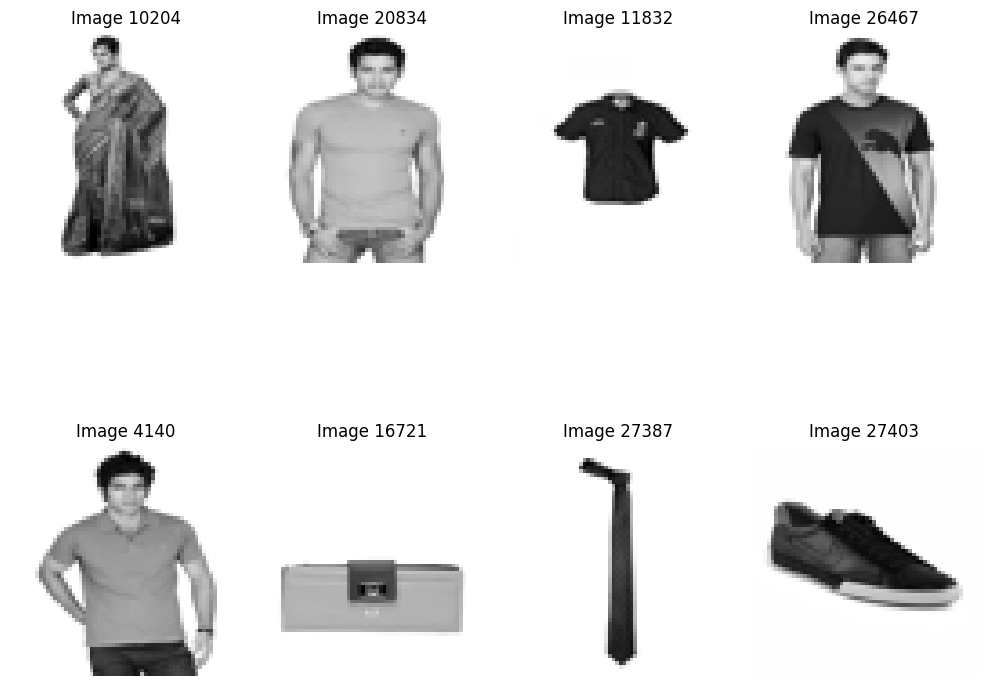

In [13]:
random_indices = np.random.choice(range(len(train_image)), size=8, replace=False)

fig, axes = plt.subplots(2, 4, figsize=(10, 10))  # Create 2 rows and 4 columns of subplots

for i, ax in enumerate(axes.flatten()):  # Flatten the 2D array of axes into 1D for easy iteration
    ax.imshow(train_image[random_indices[i]], cmap='gray')
    ax.set_title(f'Image {random_indices[i]}')  # Set the title for each subplot
    ax.axis('off')

plt.tight_layout()  # Adjust the layout to make room for the titles
plt.show()